In [1]:
import os
from glob import glob
import shutil
from pathlib import Path, PurePath

import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import torchvision
from torchvision.transforms import transforms as T
from torchvision.utils import draw_bounding_boxes

from tqdm import tqdm

import albumentations as A

import time

%matplotlib inline
torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
IMAGES = '/kaggle/input/car-segmentation/car-segmentation/images/'
MASKS = '/kaggle/input/car-segmentation/car-segmentation/masks/'
classes = '/kaggle/input/car-segmentation/car-segmentation/classes.txt'
masks = '/kaggle/input/car-segmentation/car-segmentation/masks.json'

In [4]:
len(os.listdir(IMAGES)), len(os.listdir(MASKS))

(211, 211)

In [5]:
with open(classes, 'r') as f:
    classes_file = f.read()

In [6]:
classes = classes_file[0:-1]
print(classes)
classes_list = classes.split(',')

background,car,wheel,lights,window


In [7]:
l = len(classes_list)
classes_list, len(classes_list)


(['background', 'car', 'wheel', 'lights', 'window'], 5)

In [8]:
with open(masks, 'r') as f:
    json_file = json.load(f)

## Data Viz

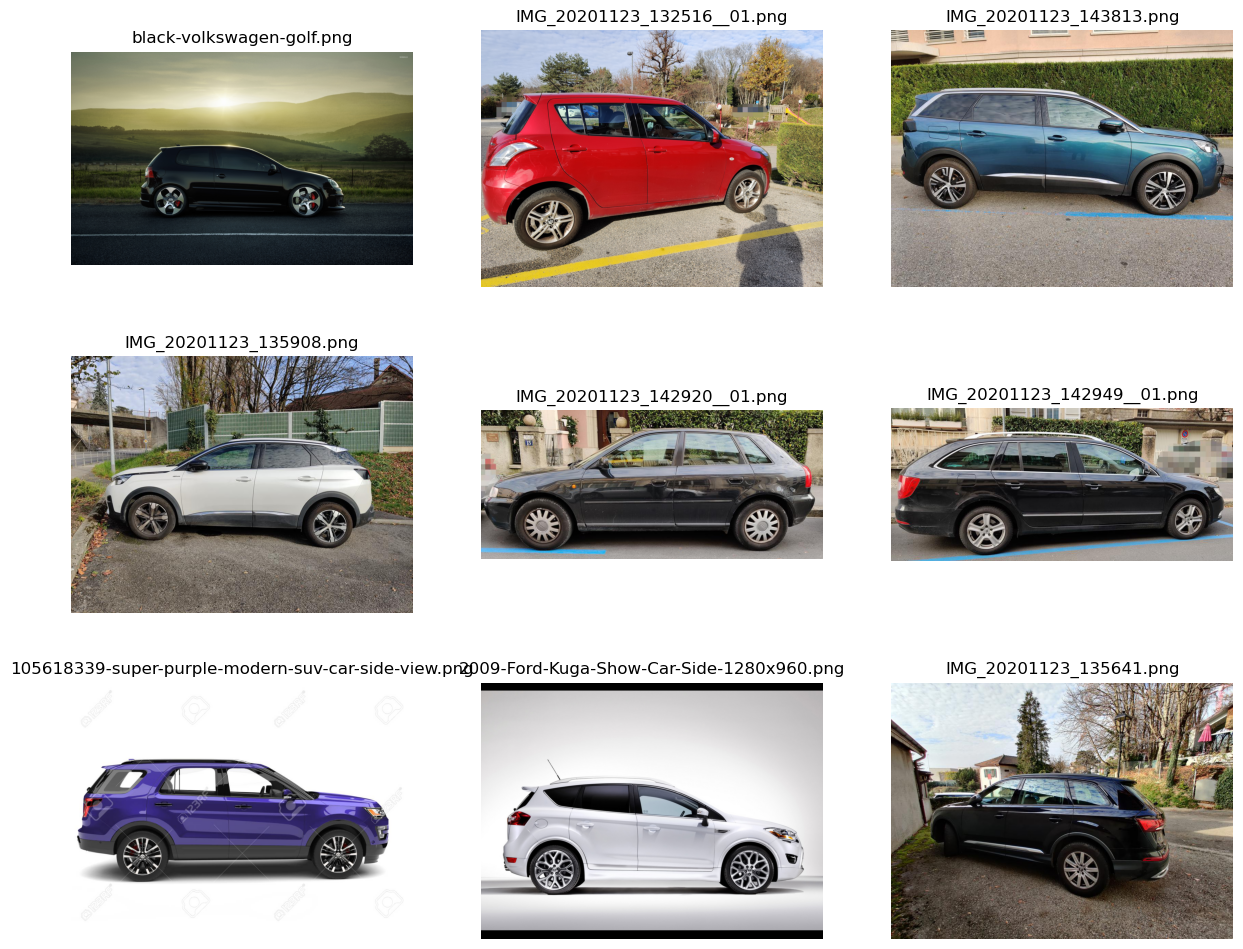

In [9]:
rows, cols = 3, 3
plt.figure(figsize=(15, 12))

images = [IMAGES + i for i in os.listdir(IMAGES)]
shapes = []
for num, x in enumerate(images):
    if num == 9:
        break
    img = Image.open(x)
    shapes.append(img.size)
    plt.subplot(rows, cols, num+1)
    plt.title(Path(x).name)
    plt.axis('off')
    plt.imshow(img)
    img.close()
    

In [10]:
shapes

[(2560, 1600),
 (4000, 3000),
 (1000, 750),
 (1000, 750),
 (1000, 434),
 (1000, 449),
 (1300, 975),
 (1280, 960),
 (1000, 750)]

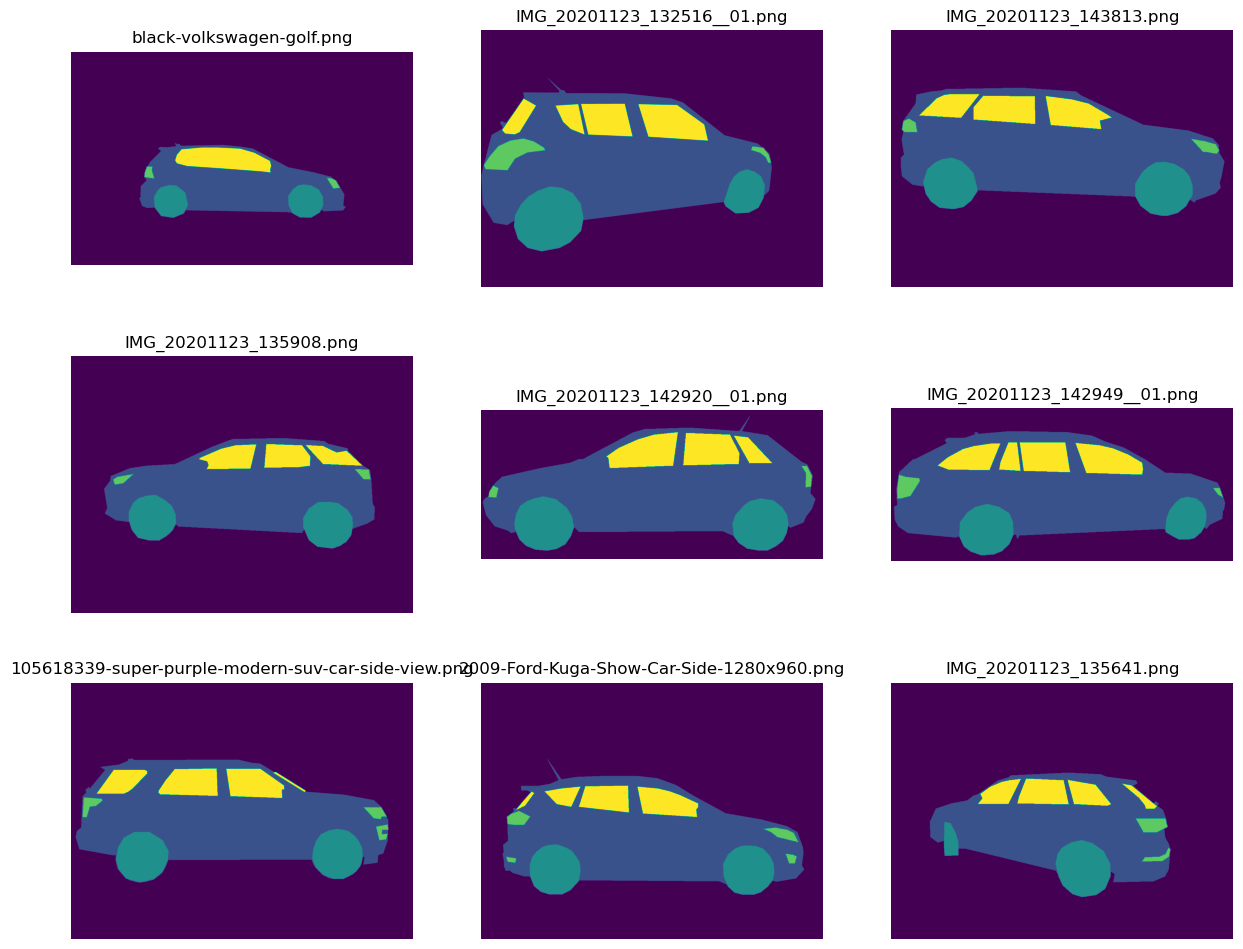

In [11]:
rows, cols = 3, 3
plt.figure(figsize=(15, 12))
mask_shapes = []
masks = [MASKS + i for i in os.listdir(MASKS)]

for num, x in enumerate(masks):
    if num == 9:
        break
    img = Image.open(x)
    mask_shapes.append(img.size)
    plt.subplot(rows, cols, num+1)
    plt.title(Path(x).name)
    plt.axis('off')
    plt.imshow(img)
    img.close()
    

In [12]:
mask_shapes

[(2560, 1600),
 (4000, 3000),
 (1000, 750),
 (1000, 750),
 (1000, 434),
 (1000, 449),
 (1300, 975),
 (1280, 960),
 (1000, 750)]

# Dataset Preparation

In [13]:
name = []
for dirname, _, filenames in os.walk(IMAGES):
    for filename in filenames:
        name.append(filename)
        
df = pd.DataFrame({'id':name}, index=np.arange(0, len(name)))

In [14]:
df.head()

,id
0,black-volkswagen-golf.png
1,IMG_20201123_132516__01.png
2,IMG_20201123_143813.png
3,IMG_20201123_135908.png
4,IMG_20201123_142920__01.png


In [15]:
size = 400

In [16]:
x_train, x_test = train_test_split(df['id'].values, test_size=0.1, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.15, random_state=42)
x_train.shape, x_val.shape, x_test.shape

((160,), (29,), (22,))

In [17]:
class CarDataset(Dataset):
    
    def __init__(self, image_path, mask_path, x, mean, std, transform=None, patch=False):
        self.img_path = image_path
        self.mask_path = mask_path
        self.x = x
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
        
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.x[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.x[idx])
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).to(torch.int64)
        
        if self.patch:
            img, mask = self.tiles(img, mask)
        
        return img, mask
    
    
    def tiles(self, img, mask):
        img_patches = img.unfold(1, size, size).unfold(2, size, size)
        img_patches = img_patches.contiguous().view(3, -1, size, size)
        img_patches = img_patches.permute(1, 0, 2, 3)
        
        mask_patches = mask.unfold(0, size, size).unfold(1, size, size)
        mask_patches = mask_patches.contiguous().view(-1, size, size)
        
        return img_patches, mask_patches
        

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(size, size, interpolation=cv2.INTER_NEAREST),
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.GridDistortion(p=0.2),
                    A.GaussNoise(),
                    A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),])

t_val = A.Compose([A.Resize(size, size, interpolation=cv2.INTER_NEAREST),
                    A.HorizontalFlip(),
                    A.GridDistortion(p=0.2),])

In [19]:
train_dataset = CarDataset(IMAGES, MASKS, x_train, mean, std, t_train, patch=False)
val_dataset = CarDataset(IMAGES, MASKS, x_val, mean, std, t_val, patch=False)

In [20]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# U-net Architecture

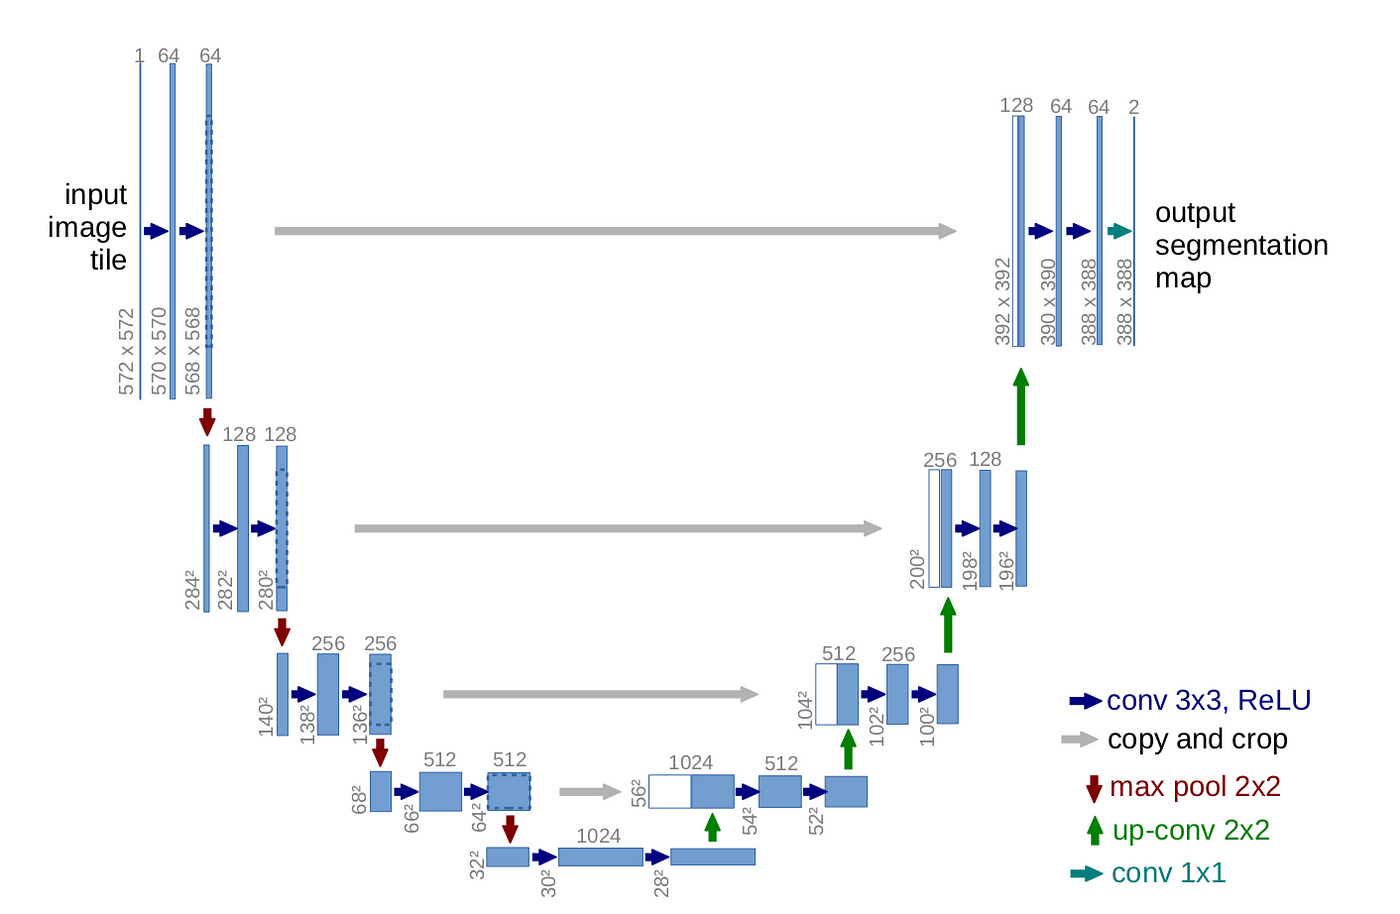

In [21]:
class UNet(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
       
        
        """
        Encoder 
        
        Every block in encoder has 2 convolution layer followed by max pooling layer, except last block which do not have max pooling layer
        
        The input to the U-Net is 400*400*channels
        
        """
        
        self.enc_blk11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.enc_blk12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.enc_blk21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_blk22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.enc_blk31 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_blk32 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.enc_blk41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_blk42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.enc_blk51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc_blk52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        
        """
        Decoder
        Here Upsampling of layers are done
        """
        
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_blk11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec_blk12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_blk21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_blk22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_blk31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_blk32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_blk41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_blk42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Output Layer
        self.out_layer = nn.Conv2d(64, n_class, kernel_size=1)
       
    
    
    def forward(self, x):
        
        # Encoder
        enc11 = self.relu(self.enc_blk11(x))
#         print("Encoder block 1 conv layer 1 ", enc11.shape)
        enc12 = self.relu(self.enc_blk12(enc11))
#         print("Encoder block 1 conv layer 2 ",enc12.shape)
        pool1 = self.pool(enc12)
#         print("Encoder block 1 pooling layer ",pool1.shape)
        
        enc21 = self.relu(self.enc_blk21(pool1))
#         print("Encoder block 2 conv layer 1 ",enc21.shape)
        enc22 = self.relu(self.enc_blk22(enc21))
#         print("Encoder block 2 conv layer 2 ",enc22.shape)
        pool2 = self.pool(enc22)
#         print("Encoder block 2 pooling layer ",pool2.shape)
        
        
        enc31 = self.relu(self.enc_blk31(pool2))
#         print("Encoder block 3 conv layer 1 ",enc31.shape)
        enc32 = self.relu(self.enc_blk32(enc31))
#         print("Encoder block 3 conv layer 2 ",enc32.shape)
        pool3 = self.pool(enc32)
#         print("Encoder block 3 pooling layer ",pool3.shape)
        
        enc41 = self.relu(self.enc_blk41(pool3))
#         print("Encoder block 4 conv layer 1 ", enc41.shape)
        enc42 = self.relu(self.enc_blk42(enc41))
#         print("Encoder block 4 conv layer 2 ", enc42.shape)
        pool4 = self.pool(enc42)
#         print("Encoder block 4 pooling layer ", pool4.shape)
        
        enc51 = self.relu(self.enc_blk51(pool4))
#         print("Encoder block 5 conv layer 1 ", enc51.shape)
        enc52 = self.relu(self.enc_blk52(enc51))
#         print("Encoder block 5 conv layer 2", enc52.shape)
        
        # Decoder
        
        up1 = self.upconv1(enc52)
#         print("Upsampling layer 1 ", up1.shape)
        up11 = torch.cat([up1, enc42], dim=1)
#         print("Upsampled value layer 1 ", up11.shape)
        dec11 = self.relu(self.dec_blk11(up11))
#         print("Decoder block 1 conv layer 1 ", dec11.shape)
        dec12 = self.relu(self.dec_blk12(dec11))
        
#         print("Decoder block 1 conv layer 2", dec12.shape)
        
        up2 = self.upconv2(dec12)
#         print("Upsampling layer 2 ", up2.shape)
        up22 = torch.cat([up2, enc32], dim=1)
#         print("Upsampled value layer 2 ", up22.shape)
        dec21 = self.relu(self.dec_blk21(up22))
#         print("Decoder block 2 conv layer 1 ", dec21.shape)
        dec22 = self.relu(self.dec_blk22(dec21))
#         print("Decoder block 2 conv layer 2 ", dec22.shape)
        
        up3 = self.upconv3(dec22)
#         print("Upsampling layer 3 ", up3.shape)
        up33 = torch.cat([up3, enc22], dim=1)
#         print("Upsampled value layer 3 ", up33.shape)
        dec31 = self.relu(self.dec_blk31(up33))
#         print("Decoder block 3 conv layer 1 ", dec31.shape)
        dec32 = self.relu(self.dec_blk32(dec31))
#         print("Decoder block 3 conv layer 2 ", dec32.shape)
        
        up4 = self.upconv4(dec32)
#         print("Upsampling layer 4 ", up4.shape)
        up44 = torch.cat([up4, enc12], dim=1)
#         print("Upsampled value layer 4 ", up44.shape)
        dec41 = self.relu(self.dec_blk41(up44))
#         print("Decoder block 4 conv layer 1 ", dec41.shape)
        dec42 = self.relu(self.dec_blk42(dec41))
#         print("Decoder block 4 conv layer 2 ", dec42.shape)
        
        out = self.out_layer(dec42)
#         print('Output ', out.shape)
       
        
        return out
        

Encoder block 1 conv layer 1  torch.Size([3, 64, 400, 400])

Encoder block 1 conv layer 2  torch.Size([3, 64, 400, 400])

Encoder block 1 pooling layer  torch.Size([3, 64, 200, 200])

Encoder block 2 conv layer 1  torch.Size([3, 128, 200, 200])

Encoder block 2 conv layer 2  torch.Size([3, 128, 200, 200])

Encoder block 2 pooling layer  torch.Size([3, 128, 100, 100])

Encoder block 3 conv layer 1  torch.Size([3, 128, 100, 100])

Encoder block 3 conv layer 2  torch.Size([3, 256, 100, 100])

Encoder block 3 pooling layer  torch.Size([3, 256, 50, 50])

Encoder block 4 conv layer 1  torch.Size([3, 512, 50, 50])

Encoder block 4 conv layer 2  torch.Size([3, 512, 50, 50])

Encoder block 4 pooling layer  torch.Size([3, 512, 25, 25])

Encoder block 5 conv layer 1  torch.Size([3, 1024, 25, 25])

Encoder block 5 conv layer 2 torch.Size([3, 1024, 25, 25])
Upsampling layer 1  torch.Size([3, 512, 50, 50])

Upsampled value layer 1  torch.Size([3, 1024, 50, 50])

Decoder block 1 conv layer 1  torch.Size([3, 512, 50, 50])

Decoder block 1 conv layer 2 torch.Size([3, 512, 50, 50])

Upsampling layer 2  torch.Size([3, 256, 100, 100])

Upsampled value layer 2  torch.Size([3, 512, 100, 100])

Decoder block 2 conv layer 1  torch.Size([3, 256, 100, 100])

Decoder block 2 conv layer 2  torch.Size([3, 256, 100, 100])

Upsampling layer 3  torch.Size([3, 128, 200, 200])

Upsampled value layer 3  torch.Size([3, 256, 200, 200])

Decoder block 3 conv layer 1  torch.Size([3, 128, 200, 200])

Decoder block 3 conv layer 2  torch.Size([3, 128, 200, 200])

Upsampling layer 4  torch.Size([3, 64, 400, 400])
Upsampled value layer 4  torch.Size([3, 128, 400, 400])

Decoder block 4 conv layer 1  torch.Size([3, 64, 400, 400])

Decoder block 4 conv layer 2  torch.Size([3, 64, 400, 400])

Output  torch.Size([3, 5, 400, 400])

In [22]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum() / float(correct.numel()))
    return accuracy

In [23]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_class = []
        for classes in range(0, n_classes):
            true_class = (pred_mask == classes)
            true_label = (mask == classes)
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
            
            

In [24]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0
    
    model.to(device)
    fit_time = time.time()
    for epoch in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        # Training
        
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            
            #Training Phase
            image_tiles, mask_tiles = data
#             print('Mask', mask_tiles.shape)
            bs, c, h, w = image_tiles.size()
#             print(bs, c, h, w)
            if patch:
                batch, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            else:
                mask_tiles = mask_tiles.view(bs, c, h, w)
                mask_tiles = mask_tiles.float()
                mask_tiles = torch.mean(mask_tiles, dim=1)
                mask_tiles = mask_tiles.long()
                
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
#             print(mask.shape)
            # Forward Prop
            output = model(image)
            
            # Loss
            loss = criterion(output, mask)
            # Evaluation
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
            # Backpropogation
            loss.backward()
            # Updating weights
            optimizer.step()
            # Clearing gradients
            optimizer.zero_grad()
            
            
            lrs.append(get_lr(optimizer))
            scheduler.step()
            running_loss += loss.item()
            
        else:
            # Validation
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            
            # Validation Phase
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    bs, c, h, w = image_tiles.size()
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    else:
                        print(mask_tiles.shape)
                        mask_tiles = mask_tiles.view(bs, c, h, w)
                        mask_tiles = mask_tiles.float()
                        mask_tiles = torch.mean(mask_tiles, dim=1)
                        mask_tiles = mask_tiles.long()
    
                        
                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    
                    # Forward prop
                    output = model(image)
                    
                    # Evaluation
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    # Loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()
            
            # Calculating Mean for Each Batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))
            
            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.... {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('Saving Model.......')
                    torch.save(model, '//kaggle//working//UNet-mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))
                    
            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f"Loss did not decrease for {not_improve} times")
                if not_improve == 7:
                    print('Loss did not decrease for 7 times, Stopped Training..')
                    break
                
            # IoU
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            
            print("Epoch: {} / {} ".format(epoch + 1, epochs),
                  "Train Loss: {:.3f} ".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f} ".format(test_loss / len(val_loader)),
                  "Train mIoU: {:.3f} ".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f} ".format(val_iou_score / len(val_loader)),
                  "Train Accuracy: {:.3f} ".format(accuracy / len(train_loader)),
                  "Val Accuracy: {:.3f} ".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))
    
    history = {
        'train_loss': train_losses,
        "val_loss": test_losses,
        'train_miou' :train_iou,
        'val_miou':val_iou,
        'train_acc' :train_acc,
        'val_acc':val_acc,
        'lrs': lrs}
    
    print("Total time: {:.2f} m".format((time.time() - fit_time) /60 ))
    return history
                        
            
            

In [25]:
model = UNet(l)
model.to(device)

UNet(
  (enc_blk11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (enc_blk21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk31): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk32): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk51): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk52): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(1024, 512, kernel_size=(2, 2), strid

In [26]:

max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler)


 10%|█         | 1/10 [00:00<00:05,  1.79it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 20%|██        | 2/10 [00:00<00:03,  2.38it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.80it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:01,  3.08it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  3.29it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.80it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:03<00:00,  2.29it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.04it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... inf >> 0.816 
Epoch: 1 / 15  Train Loss: 1.334  Val Loss: 0.816  Train mIoU: 0.230  Val mIoU: 0.243  Train Accuracy: 0.699  Val Accuracy: 0.782  Time: 0.82m


 10%|█         | 1/10 [00:00<00:03,  2.41it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:02,  2.76it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:00<00:02,  3.25it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 40%|████      | 4/10 [00:01<00:01,  3.38it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 50%|█████     | 5/10 [00:01<00:01,  3.54it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:01<00:01,  3.53it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:00,  3.12it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  3.03it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.21it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.816 >> 0.687 
Epoch: 2 / 15  Train Loss: 0.676  Val Loss: 0.687  Train mIoU: 0.264  Val mIoU: 0.248  Train Accuracy: 0.801  Val Accuracy: 0.779  Time: 0.67m


 10%|█         | 1/10 [00:00<00:05,  1.74it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:03,  2.25it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.78it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  3.15it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.66it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.36it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 80%|████████  | 8/10 [00:03<00:00,  2.64it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 90%|█████████ | 9/10 [00:03<00:00,  2.30it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.687 >> 0.668 
Epoch: 3 / 15  Train Loss: 0.640  Val Loss: 0.668  Train mIoU: 0.261  Val mIoU: 0.248  Train Accuracy: 0.803  Val Accuracy: 0.773  Time: 0.67m


 10%|█         | 1/10 [00:00<00:03,  2.49it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:03,  2.13it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.71it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:01,  3.05it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  2.88it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 60%|██████    | 6/10 [00:02<00:01,  3.12it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:00,  3.39it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  2.90it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 90%|█████████ | 9/10 [00:03<00:00,  2.46it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.668 >> 0.664 
Saving Model.......
Epoch: 4 / 15  Train Loss: 0.618  Val Loss: 0.664  Train mIoU: 0.261  Val mIoU: 0.243  Train Accuracy: 0.800  Val Accuracy: 0.783  Time: 0.67m


 67%|██████▋   | 36/54 [00:24<00:11,  1.63it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 10%|█         | 1/10 [00:00<00:04,  2.21it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 20%|██        | 2/10 [00:01<00:04,  1.94it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 30%|███       | 3/10 [00:01<00:03,  1.91it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.43it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:02<00:01,  2.75it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.75it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.65it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:03<00:00,  2.98it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  3.29it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


torch.Size([2, 400, 400, 3])
Loss did not decrease for 1 times
Epoch: 5 / 15  Train Loss: 29.017  Val Loss: 7.101  Train mIoU: 0.182  Val mIoU: 0.057  Train Accuracy: 0.552  Val Accuracy: 0.184  Time: 0.67m


 10%|█         | 1/10 [00:00<00:03,  2.71it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:03,  2.27it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:03,  2.11it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.18it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:02<00:01,  2.54it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.80it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 70%|███████   | 7/10 [00:02<00:01,  2.99it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  3.22it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 90%|█████████ | 9/10 [00:03<00:00,  3.28it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 7.101 >> 0.717 
Epoch: 6 / 15  Train Loss: 0.960  Val Loss: 0.717  Train mIoU: 0.248  Val mIoU: 0.243  Train Accuracy: 0.760  Val Accuracy: 0.785  Time: 0.66m


 10%|█         | 1/10 [00:00<00:03,  2.30it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:02,  3.04it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.36it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.82it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  3.04it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 60%|██████    | 6/10 [00:02<00:01,  3.19it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:00,  3.32it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  3.51it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.47it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.717 >> 0.662 
Epoch: 7 / 15  Train Loss: 0.630  Val Loss: 0.662  Train mIoU: 0.262  Val mIoU: 0.241  Train Accuracy: 0.802  Val Accuracy: 0.779  Time: 0.67m


 10%|█         | 1/10 [00:00<00:02,  3.76it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 20%|██        | 2/10 [00:00<00:03,  2.32it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.44it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.87it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 50%|█████     | 5/10 [00:01<00:01,  3.16it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:01<00:01,  3.42it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.81it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  3.02it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.34it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.662 >> 0.644 
Epoch: 8 / 15  Train Loss: 0.600  Val Loss: 0.644  Train mIoU: 0.264  Val mIoU: 0.242  Train Accuracy: 0.805  Val Accuracy: 0.780  Time: 0.66m


 65%|██████▍   | 35/54 [00:26<00:18,  1.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 10%|█         | 1/10 [00:00<00:03,  2.57it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:02,  3.22it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 40%|████      | 4/10 [00:01<00:01,  3.61it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  2.77it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:01<00:01,  3.05it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 70%|███████   | 7/10 [00:02<00:00,  3.20it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  2.80it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.58it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.644 >> 0.643 
Epoch: 9 / 15  Train Loss: 0.610  Val Loss: 0.643  Train mIoU: 0.259  Val mIoU: 0.249  Train Accuracy: 0.802  Val Accuracy: 0.785  Time: 0.67m


 10%|█         | 1/10 [00:00<00:02,  4.26it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:01,  4.10it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 30%|███       | 3/10 [00:00<00:02,  2.82it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:01,  3.00it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 50%|█████     | 5/10 [00:01<00:02,  2.24it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.54it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.89it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  2.81it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.51it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.643 >> 0.640 
Saving Model.......
Epoch: 10 / 15  Train Loss: 0.608  Val Loss: 0.640  Train mIoU: 0.267  Val mIoU: 0.243  Train Accuracy: 0.804  Val Accuracy: 0.781  Time: 0.68m


 10%|█         | 1/10 [00:00<00:02,  4.10it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:02,  3.03it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 30%|███       | 3/10 [00:00<00:02,  3.15it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:01,  3.55it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  3.72it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 60%|██████    | 6/10 [00:01<00:01,  2.72it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.12it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:03<00:00,  2.18it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.53it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


torch.Size([2, 400, 400, 3])
Loss did not decrease for 2 times
Epoch: 11 / 15  Train Loss: 0.612  Val Loss: 0.652  Train mIoU: 0.264  Val mIoU: 0.241  Train Accuracy: 0.801  Val Accuracy: 0.781  Time: 0.67m


 10%|█         | 1/10 [00:00<00:02,  3.49it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:02,  3.97it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.77it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.56it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:02,  2.40it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.77it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:00,  3.12it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


torch.Size([2, 400, 400, 3])
Loss did not decrease for 3 times
Epoch: 12 / 15  Train Loss: 0.611  Val Loss: 0.652  Train mIoU: 0.263  Val mIoU: 0.248  Train Accuracy: 0.800  Val Accuracy: 0.779  Time: 0.67m


 10%|█         | 1/10 [00:00<00:02,  3.54it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:03,  2.25it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.81it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.64it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.64it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 70%|███████   | 7/10 [00:02<00:01,  2.39it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:03<00:00,  2.76it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 90%|█████████ | 9/10 [00:03<00:00,  2.98it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


torch.Size([2, 400, 400, 3])
Loss Decreasing.... 0.652 >> 0.625 
Epoch: 13 / 15  Train Loss: 0.605  Val Loss: 0.625  Train mIoU: 0.261  Val mIoU: 0.251  Train Accuracy: 0.800  Val Accuracy: 0.788  Time: 0.67m


 10%|█         | 1/10 [00:00<00:02,  3.14it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:03,  2.27it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:02,  2.90it/s]

torch.Size([3, 400, 400, 3])


 40%|████      | 4/10 [00:01<00:02,  2.33it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  2.80it/s]

torch.Size([3, 400, 400, 3])


 60%|██████    | 6/10 [00:02<00:01,  2.52it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.55it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 80%|████████  | 8/10 [00:03<00:00,  2.75it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.34it/s]

torch.Size([3, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


torch.Size([2, 400, 400, 3])
Loss did not decrease for 4 times
Epoch: 14 / 15  Train Loss: 0.601  Val Loss: 0.626  Train mIoU: 0.261  Val mIoU: 0.251  Train Accuracy: 0.802  Val Accuracy: 0.788  Time: 0.68m


 10%|█         | 1/10 [00:00<00:03,  2.32it/s]

torch.Size([3, 400, 400, 3])


 20%|██        | 2/10 [00:00<00:02,  3.07it/s]

torch.Size([3, 400, 400, 3])


 30%|███       | 3/10 [00:01<00:03,  2.16it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 40%|████      | 4/10 [00:01<00:02,  2.62it/s]

torch.Size([3, 400, 400, 3])


 50%|█████     | 5/10 [00:01<00:01,  2.82it/s]

torch.Size([3, 400, 400, 3])


libpng warning: iCCP: known incorrect sRGB profile
 60%|██████    | 6/10 [00:02<00:01,  3.05it/s]

torch.Size([3, 400, 400, 3])


 70%|███████   | 7/10 [00:02<00:01,  2.40it/s]

torch.Size([3, 400, 400, 3])


 80%|████████  | 8/10 [00:02<00:00,  2.78it/s]

torch.Size([3, 400, 400, 3])


 90%|█████████ | 9/10 [00:03<00:00,  2.57it/s]

torch.Size([3, 400, 400, 3])
torch.Size([2, 400, 400, 3])


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

Loss Decreasing.... 0.626 >> 0.617 
Epoch: 15 / 15  Train Loss: 0.605  Val Loss: 0.617  Train mIoU: 0.263  Val mIoU: 0.251  Train Accuracy: 0.799  Val Accuracy: 0.788  Time: 0.67m
Total time: 10.21 m


In [27]:
torch.save(model, 'Car-Segmenatation-Unet-Mobilenet.pt')

In [28]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

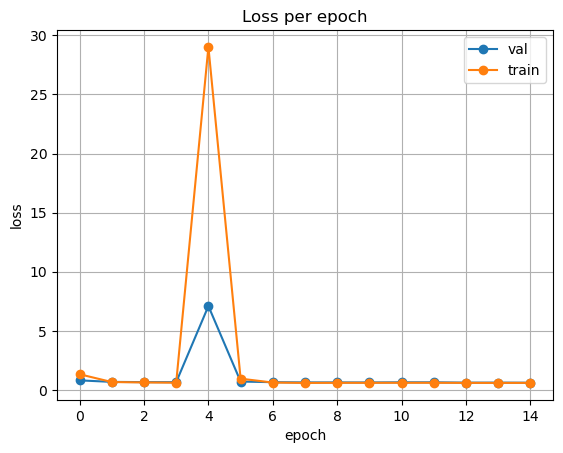

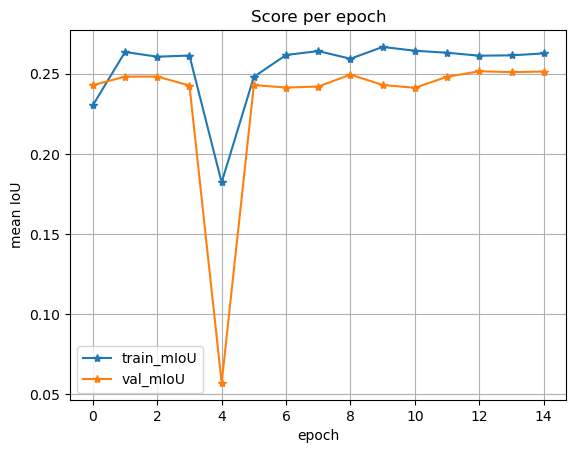

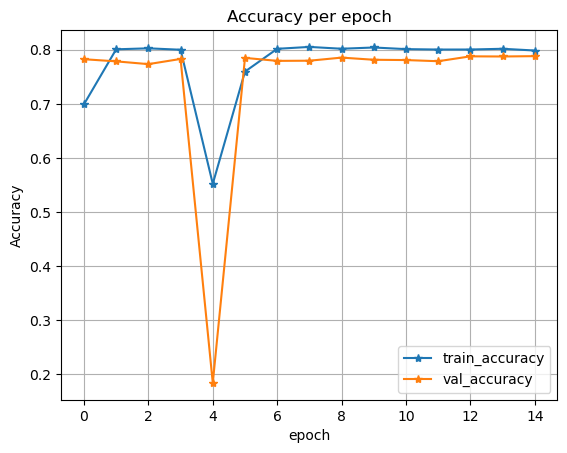

In [29]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [31]:
class CarTestData(Dataset):
    
    def __init__(self, img_path, mask_path, x, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.x = x
        self.transform = transform
        
    
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.x[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.x[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
            
        mask = torch.from_numpy(mask).long()
        
        return img, mask
    

test_data = A.Resize(size, size, interpolation=cv2.INTER_NEAREST)
test_set = CarTestData(IMAGES, MASKS, x_test, test_data)

In [55]:
def predict_image_mask_miou(model, image, mask, mean=mean, std=std):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        print(output.shape, mask.shape)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    
    return masked, score

In [56]:
def predict_image_mask_pixel(model, image, mask, mean=mean, std=std):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    
    return masked, acc

        

In [57]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

mob_miou = miou_score(model, test_set)


torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


  5%|▍         | 1/22 [00:00<00:02,  9.80it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


  9%|▉         | 2/22 [00:00<00:02,  9.69it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 18%|█▊        | 4/22 [00:00<00:01, 11.31it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 27%|██▋       | 6/22 [00:00<00:01, 13.50it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 36%|███▋      | 8/22 [00:00<00:00, 14.09it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 45%|████▌     | 10/22 [00:00<00:00, 14.15it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 55%|█████▍    | 12/22 [00:00<00:00, 13.72it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 64%|██████▎   | 14/22 [00:01<00:00, 13.66it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 73%|███████▎  | 16/22 [00:01<00:00,  7.82it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


 91%|█████████ | 20/22 [00:01<00:00, 10.27it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


100%|██████████| 22/22 [00:01<00:00, 11.10it/s]

torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])
torch.Size([1, 5, 400, 400]) torch.Size([1, 400, 400])


In [48]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy
mob_acc = pixel_acc(model, test_set)


100%|██████████| 22/22 [00:01<00:00, 12.03it/s]


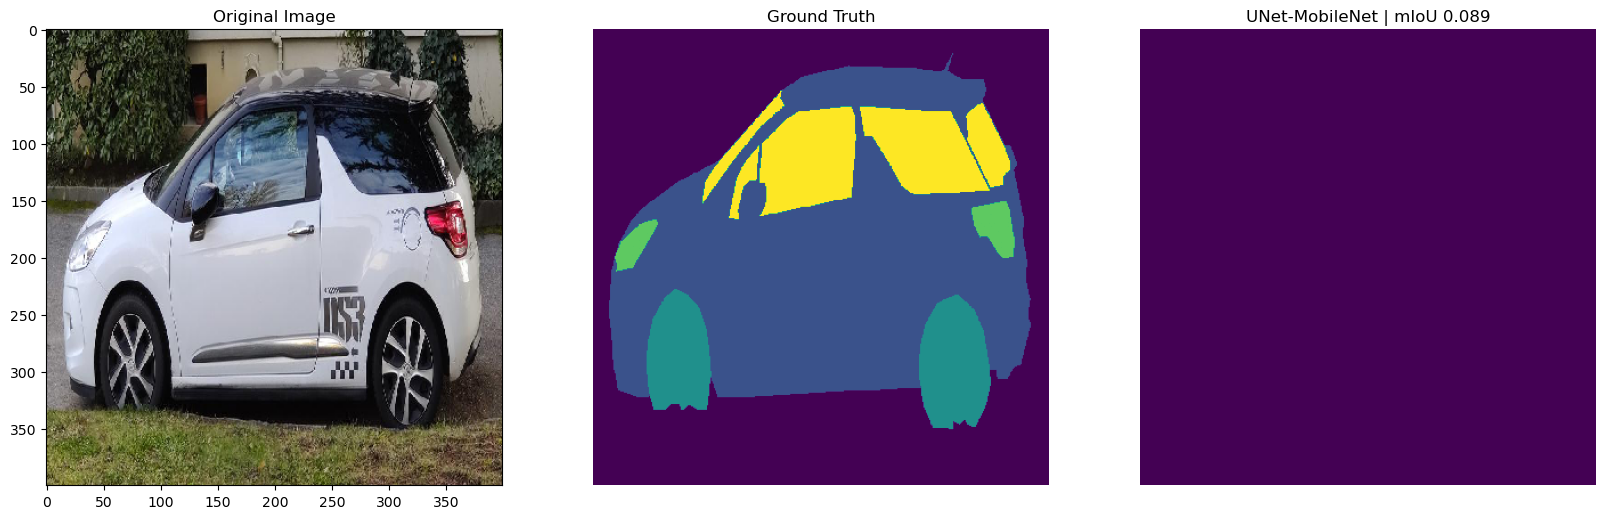

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title('Original Image')

ax2.imshow(mask)
ax2.set_title('Ground Truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()


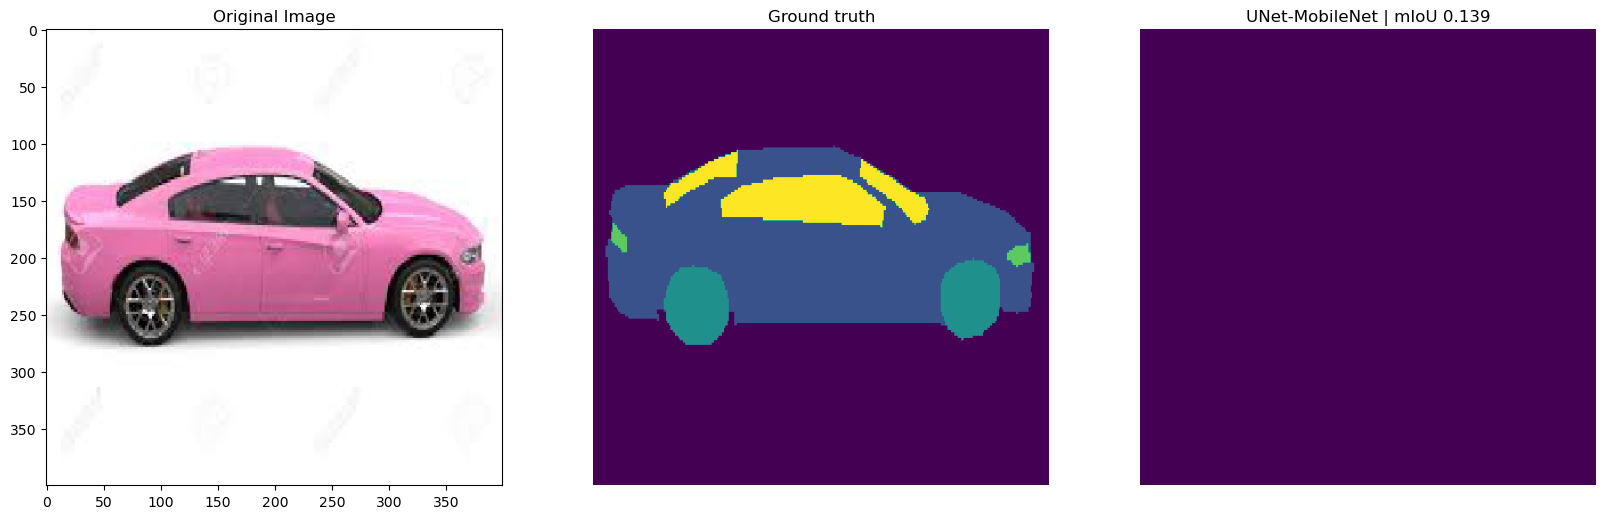

In [50]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image2)
ax1.set_title("Original Image")

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()


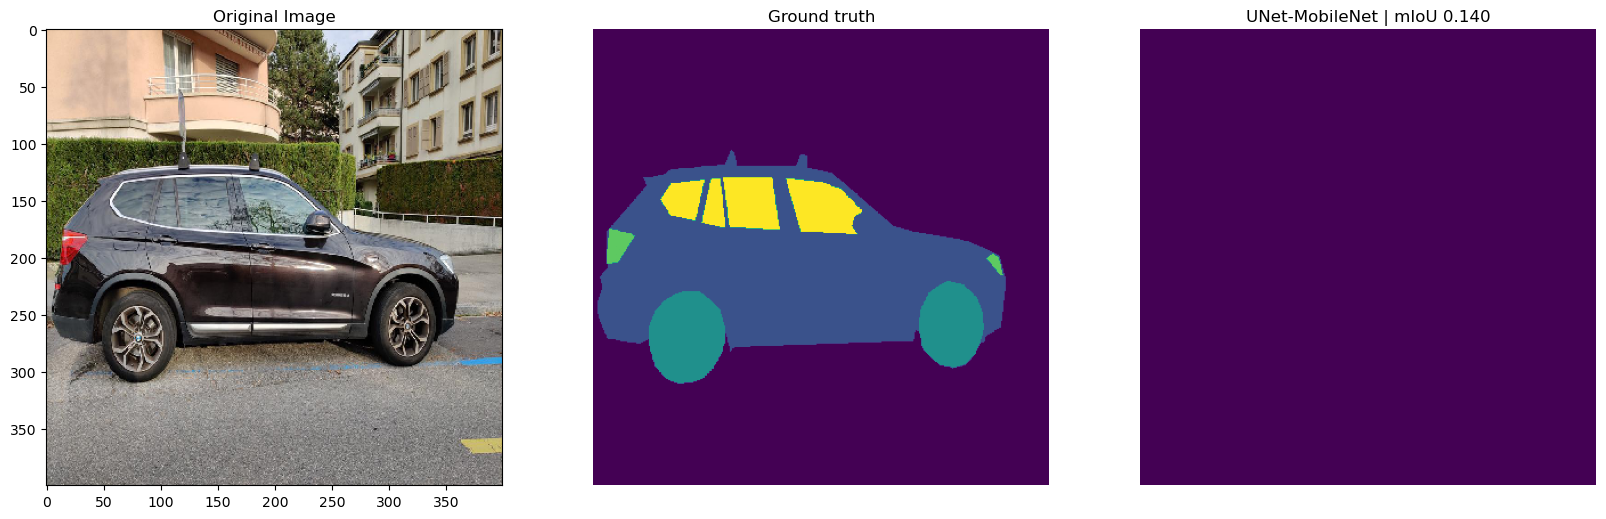

In [51]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Original Image');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()


In [53]:
pred_mask3

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [54]:

print('Test Set mIoU', np.mean(mob_miou))

print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.12643267045458895
Test Set Pixel Accuracy 0.6321633403951471


# The model is only detecting background need more data or tuning of model 